In [50]:
import torch
import pandas as pd
from transformers import BertTokenizer, BertModel
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Define your dataset class
class CustomDataset(Dataset):
    def __init__(self, dataframe, max_len=100):
        self.data = dataframe
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data.loc[idx, 'Text']

        inputs = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        label = self.data.loc[idx, 'Class']  # Get label as string

        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'label': label
        }

# Load the dataset from Excel
data = pd.read_excel('/content/sentiment_analysis.xlsx')

# Map string labels to numerical labels
label_map = {"Positive": 0, "Negative": 1}
data['Class'] = data['Class'].map(label_map)

print(data)
print(data['Class'] )

# Define dataset and dataloader
batch_size = 1
dataset = CustomDataset(data)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Function to extract features using BERT
def extract_features(model, dataloader):
    features = []
    targets = []

    model.eval()

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Extracting Features"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            label = batch['label']  # No need to convert to device

            outputs = model(input_ids, attention_mask=attention_mask)
            pooled_output = outputs[1]  # Using the [CLS] token representation

            features.append(pooled_output.cpu().numpy())
            targets.extend(label)  # Extend list with string labels

    return features, targets

# Extract features for the entire dataset
features, targets = extract_features(model, loader)

targets = torch.tensor(targets, dtype=torch.long)  # Convert to tensor

# features = torch.cat(features, dim=0)
listFeatures =[]
for item in features:
  listFeatures.append(item[0])

targets_np = targets.numpy()

# Convert to DataFrame
df = pd.DataFrame(listFeatures)
df['target'] = targets_np

# Save to Excel
df.to_excel('sentiment_analysis_classification.xlsx', index=False)


                                                  Text  Class
0         The sky is clear and the weather is perfect.      0
1     I'm surrounded by loving and supportive friends.      0
2      I achieved a personal best in my workout today.      0
3    The aroma of freshly brewed coffee fills the r...      0
4    I received a promotion at work, and I'm thrilled.      0
..                                                 ...    ...
195        I'm frustrated by my own negative thoughts.      1
196  I'm disappointed by the lack of support from t...      1
197          I'm overwhelmed by the challenges I face.      1
198  I'm frustrated by my inability to meet my own ...      1
199  I'm disappointed by the lack of progress I've ...      1

[200 rows x 2 columns]
0      0
1      0
2      0
3      0
4      0
      ..
195    1
196    1
197    1
198    1
199    1
Name: Class, Length: 200, dtype: int64


Extracting Features: 100%|██████████| 200/200 [02:05<00:00,  1.60it/s]


In [57]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

# Load Iris dataset from Excel file
data_df = pd.read_excel('/content/sentiment_analysis_classification.xlsx')
X = data_df.iloc[:, :-1].values
y = data_df.iloc[:, -1].values


print(X.shape)
print(y.shape)

print(X)
print(y)



(200, 768)
(200,)
[[-0.93002754 -0.61344254 -0.98443389 ... -0.89174587 -0.80218297
   0.94946283]
 [-0.81158787 -0.29763407 -0.39346984 ... -0.36799353 -0.5658893
   0.84640068]
 [-0.89600927 -0.46713668 -0.64178783 ... -0.51123989 -0.64971572
   0.93851095]
 ...
 [-0.86882538 -0.4027527  -0.7371577  ... -0.63429552 -0.63517278
   0.88311857]
 [-0.83500439 -0.30412072 -0.59105349 ... -0.41155165 -0.54118675
   0.86236709]
 [-0.84934598 -0.24700139 -0.59189051 ... -0.34642014 -0.50722831
   0.86930555]]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


(200, 768)
(200,)
Epoch [50/1000], Loss: 0.3634
Epoch [100/1000], Loss: 0.3178
Epoch [150/1000], Loss: 0.3148
Epoch [200/1000], Loss: 0.3141
Epoch [250/1000], Loss: 0.3138
Epoch [300/1000], Loss: 0.3136
Epoch [350/1000], Loss: 0.3135
Epoch [400/1000], Loss: 0.3134
Epoch [450/1000], Loss: 0.3134
Epoch [500/1000], Loss: 0.3134
Epoch [550/1000], Loss: 0.3134
Epoch [600/1000], Loss: 0.3133
Epoch [650/1000], Loss: 0.3133
Epoch [700/1000], Loss: 0.3133
Epoch [750/1000], Loss: 0.3133
Epoch [800/1000], Loss: 0.3133
Epoch [850/1000], Loss: 0.3133
Epoch [900/1000], Loss: 0.3133
Epoch [950/1000], Loss: 0.3133
Epoch [1000/1000], Loss: 0.3133


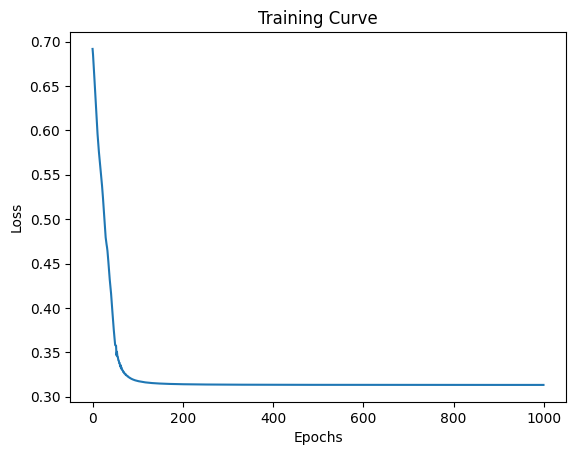

Training Confusion Matrix:
[[79  0]
 [ 0 81]]
Training Accuracy: 1.0

Testing Confusion Matrix:
[[21  0]
 [ 0 19]]
Testing Accuracy: 1.0


In [56]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Load dataset from Excel file
data_df = pd.read_excel('/content/sentiment_analysis_classification.xlsx')
X = data_df.iloc[:, :-1].values
y = data_df.iloc[:, -1].values

# Apply Min-Max scaling
print(X.shape)
print(y.shape)

# Apply Min-Max scaling
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Convert numpy arrays to PyTorch tensors
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

# Define MLP architecture
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return torch.softmax(x, dim=1)  # Apply softmax activation for multi-class classification

# Define training function
def train(model, criterion, optimizer, X_train, y_train, num_epochs=100):
    train_losses = []

    for epoch in range(num_epochs):
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        if (epoch+1) % 50 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    return train_losses

# Initialize the model, loss function, and optimizer
input_size = 768
hidden_size1 = 100
hidden_size2 = 50
output_size = 2
model = MLP(input_size, hidden_size1, hidden_size2, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
train_losses = train(model, criterion, optimizer, X_train, y_train, num_epochs=1000)

# Plot the training curve
plt.plot(train_losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Curve')
plt.show()

# Predict classes for training set
with torch.no_grad():
    train_outputs = model(X_train)
    _, train_predicted = torch.max(train_outputs, 1)

# Calculate confusion matrix and accuracy for training set
train_cm = confusion_matrix(y_train.numpy(), train_predicted.numpy())
train_accuracy = accuracy_score(y_train.numpy(), train_predicted.numpy())

print("Training Confusion Matrix:")
print(train_cm)
print("Training Accuracy:", train_accuracy)

# Predict classes for test set
with torch.no_grad():
    test_outputs = model(X_test)
    _, test_predicted = torch.max(test_outputs, 1)

# Calculate confusion matrix and accuracy for test set
test_cm = confusion_matrix(y_test.numpy(), test_predicted.numpy())
test_accuracy = accuracy_score(y_test.numpy(), test_predicted.numpy())

print("\nTesting Confusion Matrix:")
print(test_cm)
print("Testing Accuracy:", test_accuracy)


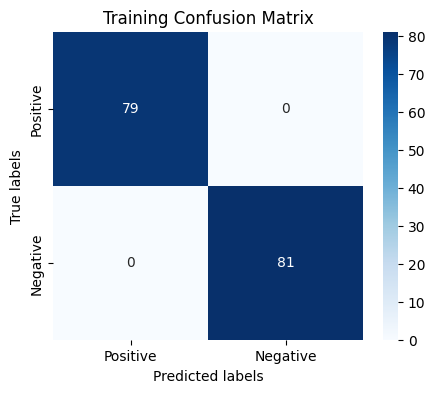

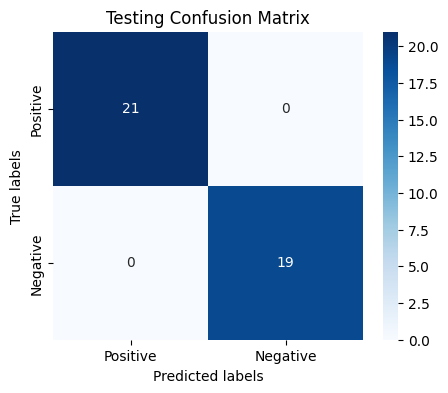

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns

# Predict classes for training set
with torch.no_grad():
    train_outputs = model(X_train)
    _, train_predicted = torch.max(train_outputs, 1)

# Calculate confusion matrix for training set
train_cm = confusion_matrix(y_train.numpy(), train_predicted.numpy())

# Plot training confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(train_cm, annot=True, cmap='Blues', fmt='g', xticklabels=['Positive', 'Negative'], yticklabels=['Positive', 'Negative'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Training Confusion Matrix')
plt.show()

# Predict classes for test set
with torch.no_grad():
    test_outputs = model(X_test)
    _, test_predicted = torch.max(test_outputs, 1)

# Calculate confusion matrix for test set
test_cm = confusion_matrix(y_test.numpy(), test_predicted.numpy())

# Plot testing confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(test_cm, annot=True, cmap='Blues', fmt='g', xticklabels=['Positive', 'Negative'], yticklabels=['Positive', 'Negative'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Testing Confusion Matrix')
plt.show()
